In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from scipy.stats import multivariate_normal
from scipy.special import softmax

# Unsupervised learning

## Exercise 11.1: PCA on MNIST

In the lectures the principal component analysis (PCA) was introduced as a method for dimensionality reduction and feature extraction, i.e., to condense data by mapping it to a lower dimensional space of the most important features.

### Theoretical background

Let
\begin{equation*}
  \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\intercal \\ \vdots \\
    \mathbf{x}_N^\intercal \end{bmatrix} \in \mathbb{R}^{N \times D}
\end{equation*}
be a matrix of $N$ data samples $\mathbf{x}_n \in \mathbb{R}^D$, which are
centered around zero.
We consider a PCA with $M < D$ components.

To project the data points $\mathbf{x}_n$ to the $M$-dimensional space that is
defined by the $M$ principal components of $\mathbf{X}$, the so-called principal
subspace of $\mathbf{X}$, we can use the singular value decomposition of
$\mathbf{X}$. Let $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\mathsf{T}$ be the
singular value decomposition of the data matrix $\mathbf{X}$ with the singular
values sorted in descending order.

Then the projection $\mathbf{z}_n$ of
data point $\mathbf{x}_n$ to the principal subspace of $\mathbf{X}$ is given by
\begin{equation}
  \mathbf{z}_n^\mathsf{T} = \mathbf{x}_n^\mathsf{T} \begin{bmatrix} \mathbf{v}_1 & \cdots & \mathbf{v}_M \end{bmatrix},
\end{equation}
where $\mathbf{v}_i$ is the $i$th column of matrix $\mathbf{V}$. The vector
$\mathbf{z}_n$ can be seen as an encoding of the data point
$\mathbf{x}_n$ in a lower dimensional space that is constructed by the directions
for which the data shows the largest variations.

With the help of the singular value decomposition of $\mathbf{X}$, we can also compute
reconstructions (or "decodings") $\tilde{\mathbf{x}}_n$ from the encodings $\mathbf{z}_n$ by
\begin{equation*}
  \tilde{\mathbf{x}}_n^\intercal = \mathbf{z}_n^\intercal \begin{bmatrix} \mathbf{v}^\intercal_1 \\ \vdots \\ \mathbf{v}^\intercal_M \end{bmatrix}.
\end{equation*}
If we use $M < D$ components, usually we are not able to recover the original data
from the lower dimensional encodings exactly. Ideally, we would like the
reconstructions to be as good as possible while keeping $M$ as small as possible.

##### Note

The singular value decomposition of a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$
is defined as a factorization of the form $\mathbf{X} = \mathbf{U} \mathbf{\Sigma}
\mathbf{V}^\mathsf{T}$ where $\mathbf{U} \in \mathbb{R}^{N \times N}$ and
$\mathbf{V} \in \mathbb{R}^{D \times D}$ are orthogonal matrices and
$\mathbf{\Sigma} \in \mathbb{R}^{N \times D}$ is a rectangular diagonal matrix with
non-negative numbers on the diagonal. The diagonal entries of $\mathbf{\Sigma}$ are
the so-called singular values of $\mathbf{X}$. A common convention is to sort
the singular values in descending order, in which case the diagonal matrix $\mathbf{\Sigma}$ is uniquely determined by $\mathbf{X}$.

### Introduction

In this exercise, we perform and analyse PCA of the MNIST image data set. The MNIST data set consists of 60000 training and 10000 test data points. Each data point consists of a grayscale image with 28 $\times$ 28 pixels of a handwritten digit. The digit has been size-normalized and centered within a fixed-sized image. Each image is also labeled with the digit (0, 1, ..., 8, or 9) it is depicting.

The following code block loads the MNIST data set.

In [2]:
# load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# normalize images to [0, 1]
images = images / 255

# convert labels to integers
labels = labels.astype(int)

# split into training and test dataset
train_images, train_labels = images[:60_000], labels[:60_000]
test_images, test_labels = images[60_000:], labels[60_000:]

/Users/emiresenov/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The images are loaded as vectors $\mathbf{x} = [x_1 \dots x_{784}]^\mathsf{T}$ where each input variable $x_j$ corresponds to one of the $28 \times 28 = 784$ pixels in the image. The figure below shows the first 100 images in the training data set.

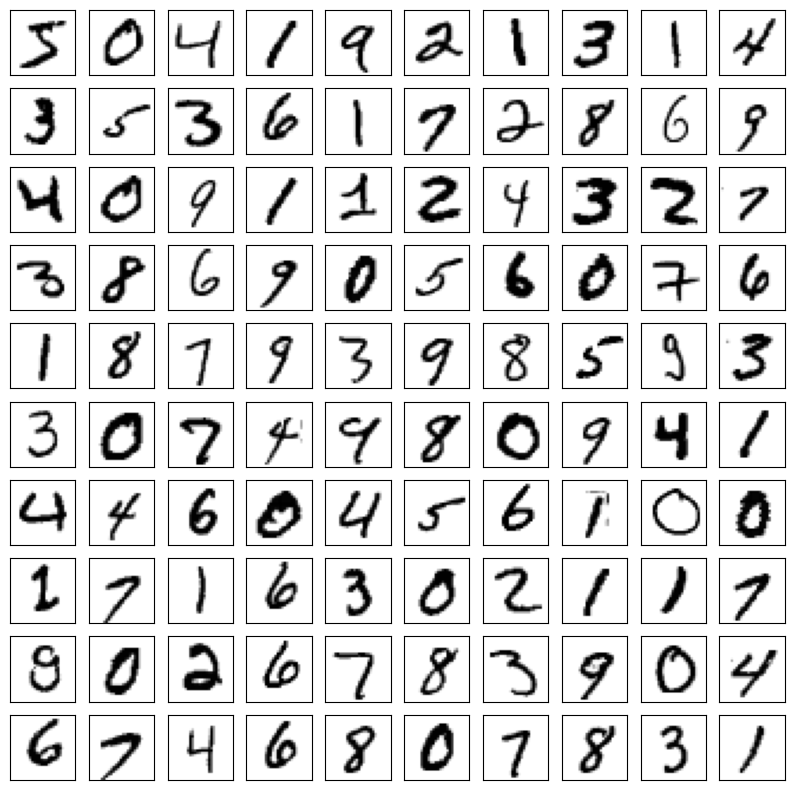

In [3]:
# plot first 100 training images
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for image, ax in zip(train_images, axes.flat):
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.imshow(image.reshape(28, 28), vmin=0.0, vmax=1.0, cmap='gray_r')
plt.show()

Let
\begin{equation*}
  \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\mathsf{T} \\ \vdots \\
    \mathbf{x}_{60000}^\mathsf{T} \end{bmatrix} \in \mathbb{R}^{60000 \times 784}
\end{equation*}
be a matrix of the MNIST training data set where each row $\mathbf{x}_i^\mathsf{T}$ represents an image of the training data set (all pixels are normalized to the interval $[0, 1]$). This matrix is huge, it contains $60000 \times 784 = 47040000$ entries!

Many entries in this matrix are zeros (corresponding to white pixels), and in particular the entries corresponding to white pixels close to the margins of an image are probably not informative and not relevant. In this exercise we will study how much information is lost if we compress the MNIST data set to $M = 2$ principal components.

We define the mean of the training images as
\begin{equation*}
    \overline{\mathbf{x}} = \frac{1}{60000} \sum_{i=1}^{60000} \mathbf{x}_i,
\end{equation*}
and hence the centered training images are given by $\mathbf{X} - \overline{\mathbf{x}}^\mathsf{T}$.

We compute the singular value decomposition $\mathbf{X} - \overline{\mathbf{x}}^\mathsf{T} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^\mathsf{T}$ of the centered MNIST training data with the function [`numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).

In [4]:
# center training images
train_mean = train_images.mean(axis=0)
train_images_centered = train_images - train_mean

U, S, Vt = np.linalg.svd(train_images_centered, full_matrices=False)

Variable `S` contains the singular values of `train_images_centered`, in descending order.

In [5]:
# four largest singular values
S[:4]

array([554.08236184, 473.79289646, 441.76832659, 412.90967564])

Note that `Vt` correspods to $\mathbf{V}^\mathsf{T}$, i.e., it is the transpose of $\mathbf{V}$. We can recover `train_images_centered` from its singular value decomposition `U`, `S`, and `Vt`.

In [6]:
np.allclose(train_images_centered, U @ np.diag(S) @ Vt)

True

In [7]:
# alternative:
np.allclose(train_images_centered, (U * S) @ Vt)

True

### (a)

Compute the two-dimensional encodings of the images in the MNIST training and the test data set in the two-dimensional latent space spanned by the $M = 2$ principal components of the centered training data, the so-called principal subspace.

*Hints*:
- Make use of `U`, `S`, and/or `Vt`.
- Remember that the presence of the center $\overline{\textbf{x}}$ needs to be accounted for in the test data as well.

In [8]:
train_encodings = train_images_centered @ Vt.T[:, :2]
test_centered = test_images - train_mean
test_encodings = test_centered @ Vt.T[:, :2]

Generate 2D scatter plots of the encodings that show the clusters for different labels in the latent space. You can make use of the function `plot_encodings` below.

In [9]:
# plot `train_encodings` and `test_encodings` with colorcoding of the corresponding labels
def plot_encodings(train_encodings, train_labels, test_encodings, test_labels):
    # create two plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # plot encodings of training data
    ax = axes[0]
    ax.scatter(
        train_encodings[:, 0], train_encodings[:, 1],
        c=train_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("training data")
    
    # plot encodings of test data
    ax = axes[1]
    scatter = ax.scatter(
        test_encodings[:, 0], test_encodings[:, 1],
        c=test_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("test data")

    # add colorbar
    cb = fig.colorbar(scatter, ticks=range(10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")
    
    return fig

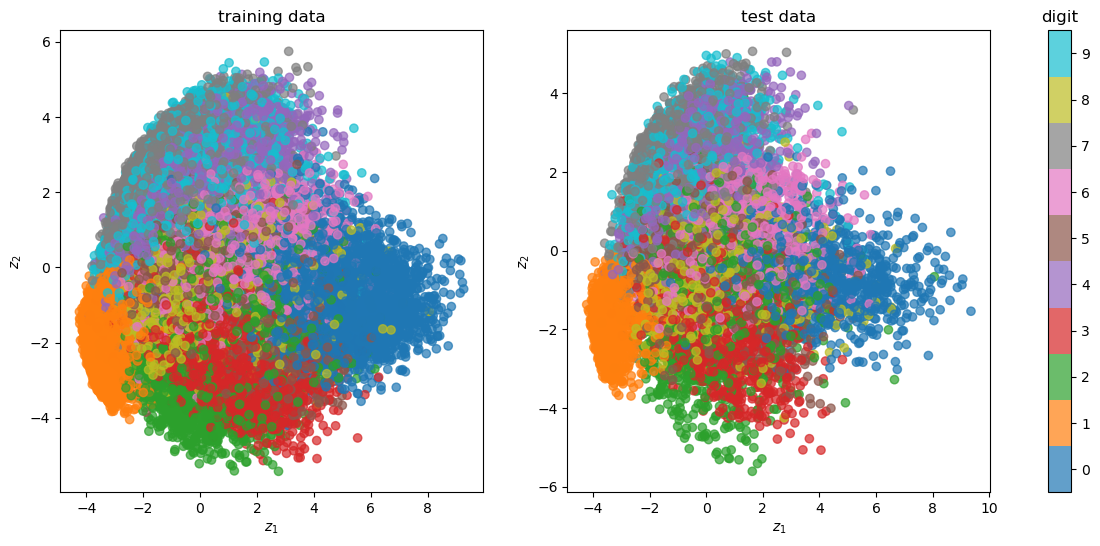

In [10]:
plot_encodings(train_encodings, train_labels, test_encodings, test_labels)
plt.show()

### (b)

Compute the reconstructions of the test images by mapping the encodings of the test data from the latent space back to the space of images.

In [14]:
test_reconstructions = train_mean + test_encodings @ Vt[:2, :]

Plot some test images and their reconstructed counterparts. You can use the function `plot_reconstructions` below. Which digits can be reconstructed and decoded quite well, and which ones seem to be more challenging? Remember that the reconstructions are obtained by considering only the two principal components.

In [15]:
# plot a grid of random pairs of `originals` and `reconstructions`
def plot_reconstructions(originals, reconstructions, labels, num_rows=4, num_cols=2):
    # indices of displayed samples
    n = originals.shape[0]
    indices = np.random.choice(n, size=num_rows*num_cols, replace=False)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    for (idx, ax) in zip(indices, axes.flat):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.set_title(f"Label: {label}", fontweight='bold')

        # plot original and reconstructed image in a grid
        grid = np.ones((32, 62))
        grid[2:30, 2:30] = original.reshape(28, 28)
        grid[2:30, 32:60] = reconstruction.reshape(28, 28)
        ax.imshow(grid, vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

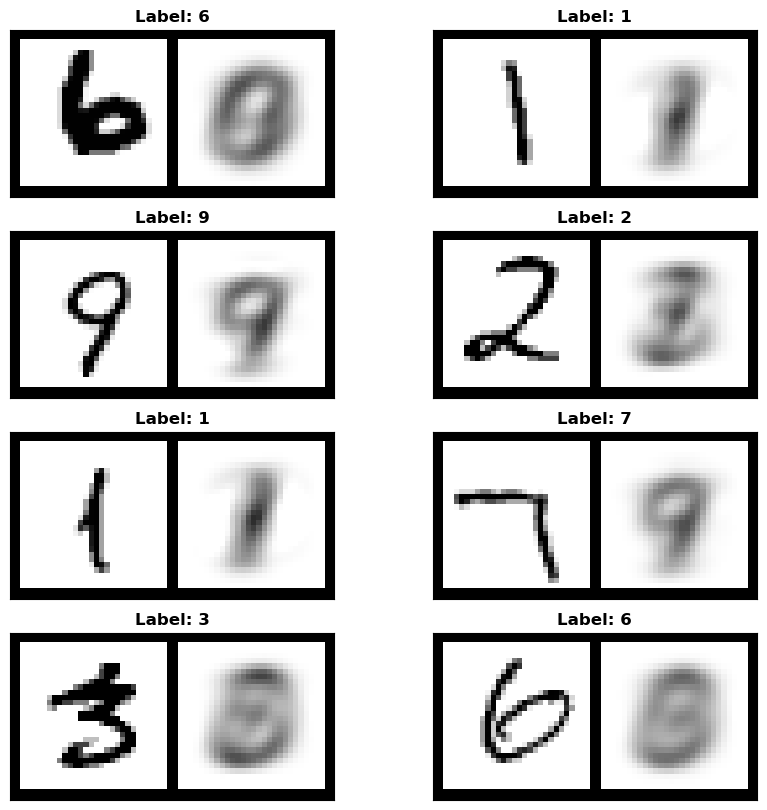

In [16]:
plot_reconstructions(test_images, test_reconstructions, test_labels)
plt.show()

### (c)

The comparison of the original images and their reconstructions provides us with some intuition for how much information is lost by the compression of the images to the two-dimensional latent space. As a less subjective measure we calculate the average squared reconstruction error
\begin{equation*}
\mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstructions $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set. An advantage of an objective measure such as the average squared reconstruction error is that it enables us to compare the PCA with other models for dimensionality reduction.

What average squared reconstruction error do you get with PCA?

In [17]:
sqerr = ((test_images - test_reconstructions)**2).sum(axis=1).mean()
print(f'Average squared reconstruction error: {sqerr}')

Average squared reconstruction error: 43.64488141639828


## Exercise 11.2 - Derivations for probabilistic PCA


In constrast to (regular) PCA, the so-called probabilistic PCA (PPCA) allows a probabilistic interpretation of the principal components. The probabilistic formulation of PCA also allows us to extend the method and alter its underlying assumptions quite easily.

As in exercise 11.1, let $\mathbf{x} \in \mathbb{R}^D$ represent a data sample that we
want to decode from a lower dimensional representation
$\mathbf{z} \in \mathbb{R}^M$ with $M < D$. The PPCA model assumes that
$\mathbf{z}$ is standard normally distributed and $\mathbf{x}$
can be decoded by a noisy linear transformation of $\mathbf{z}$.
Mathematically, the model is given by
\begin{align*}
  p(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mathbf{W}\mathbf{z} + \boldsymbol{\mu}, \sigma^2 \mathbf{I}_D\right), \\
  p(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_M),
\end{align*}
with parameters $\mathbf{W} \in \mathbb{R}^{D \times M}$,
$\boldsymbol{\mu} \in \mathbb{R}^D$, and $\sigma^2 > 0$.
[Michael E. Tipping and Christopher M. Bishop show in "Probabilistic Principal Component Analysis"](https://www.jstor.org/stable/2680726)
that for $\sigma^2 \to 0$
the model recovers the standard PCA (but the components of $\mathbf{z}$ might
be permuted).

We assume that the data $\mathbf{x}_1, \ldots, \mathbf{x}_N$ is identically
and independently distributed according to the PPCA model. In a maximum
likelihood setting, one determines the parameters $\mathbf{W}$, $\boldsymbol{\mu}$,
and $\sigma^2$ that maximize the likelihood
\begin{equation*}
  p(\mathbf{x}_1, \ldots, \mathbf{x}_N ; \mathbf{W}, \boldsymbol{\mu}, \sigma^2)
  = \prod_{n=1}^N p(\mathbf{x}_n; \mathbf{W}, \boldsymbol{\mu}, \sigma^2),
\end{equation*}
or equivalently the log-likelihood
\begin{equation*}
  \log p(\mathbf{x}_1, \ldots, \mathbf{x}_N; \mathbf{W}, \boldsymbol{\mu}, \sigma^2)
  = \sum_{n=1}^N \log p(\mathbf{x}_n; \mathbf{W}, \boldsymbol{\mu}, \sigma^2).
\end{equation*}

### (a) 

*(Pen and paper exercise)*

Show that for the model of the probabilistic PCA
\begin{equation*}
    p(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \mathbf{C}),
\end{equation*}
where $\mathbf{C} = \mathbf{W}\mathbf{W}^\mathsf{T} + \sigma^2 \mathbf{I}_D$.

### (b)

*(Pen and paper exercise)*

Show that the distribution of the latent variable $\mathbf{z}$ conditioned on $\mathbf{x}$ is Gaussian as well and given by
\begin{equation*}
    p(\mathbf{z} \,|\, \mathbf{x}) = \mathcal{N}\left(\mathbf{z}; \mathbf{M}^{-1} \mathbf{W}^\mathsf{T} (\mathbf{x} - \boldsymbol{\mu}), \sigma^2 \mathbf{M}^{-1} \right),
\end{equation*}
where $\mathbf{M} = \mathbf{W}^\mathsf{T} \mathbf{W} + \sigma^2 \mathbf{I}_M$.

## Exercise 11.3: Gaussian Mixture Model

In this exercise we estimate the parameters of a Gaussian mixture model with the expectation-maximization (EM) algorithm.

A Gaussian mixture model with $m \geq 1$ components consists of $m$ mixture components $\mathcal{N}(\mu_1, \Sigma_1), \ldots, \mathcal{N}(\mu_m, \Sigma_m)$ and corresponding non-negative mixture weights $w_1, \ldots, w_m$ with $\sum_{i=1}^m w_i = 1$. It has the probability density function
\begin{equation*}
    \operatorname{GMM}(x; w_1, \mu_1, \Sigma_1, \ldots, w_m, \mu_m, \Sigma_m) = \sum_{i=1}^m w_i \mathcal{N}(x; \mu_i, \Sigma_i).
\end{equation*}
One can obtain a sample $x$ from the Gaussian mixture model with a two-step procedure:
- Sample an index $d$ from the categorical distribution with probabilities $w_1, \ldots, w_m$.
- Sample $x$ from $\mathcal{N}(\mu_d, \Sigma_d)$.

We consider a data set $\mathbf{X} \in \mathbb{R}^{300 \times 2}$ of 300 samples that are generated from a two-dimensional Gaussian mixture model with mixture weights $w_1 = 0.7$ and $w_2 = 0.3$ and mixture components with parameters
\begin{equation*}
    \mu_1 = \begin{bmatrix} 5 \\ 7\end{bmatrix}, \quad \Sigma_1 = \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}, \quad
    \mu_2 = \begin{bmatrix} 1 \\ 2\end{bmatrix}, \quad \Sigma_2 = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}.
\end{equation*}

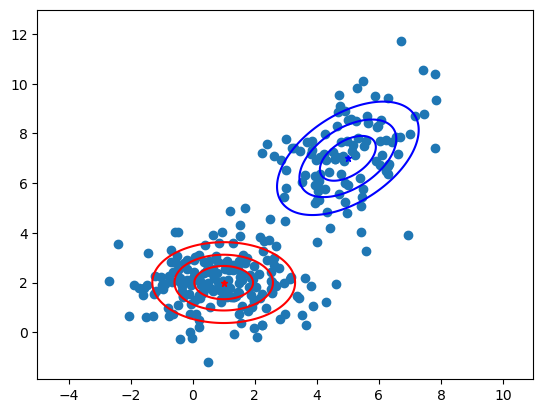

In [18]:
def plot_2dnormal(normal, color):
    # plot center
    plt.plot(normal.mean[0], normal.mean[1], '*', ms=5, color=color)

    # get countour grid
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    
    # rescale x, y
    x = normal.cov[0,0] * x + normal.mean[0]
    y = normal.cov[1,1] * y + normal.mean[1]
    
    # plot countour
    pos = np.dstack((x, y)) 
    plt.contour(x, y, normal.pdf(pos), colors=color, levels=3)

# mixture weights
weights = [0.7, 0.3]

# mixture components
component1 = multivariate_normal(mean=[1, 2], cov=[[2, 0], [0, 1]])
component2 = multivariate_normal(mean=[5, 7], cov=[[2, 1], [1, 2]])
components = [component1, component2]

# sample N = 300 samples from the Gaussian mixture model
np.random.seed(1234) # for reproducibility
N = 300
X = np.stack([np.random.choice(components, p=weights).rvs() for _ in range(N)])

plt.figure()
plt.scatter(X[:,0], X[:,1])
plot_2dnormal(component1, color='red')
plot_2dnormal(component2, color='blue')
plt.show()

### (a)

Implement a function `e_step(X, weights, components)` that receives as input
- data `X` (an array of size $300 \times 2$ in the model above),
- mixture `weights` (a list `[p, 1 - p]` in the model above), and
- mixture `components` (a list of two [`multivariate_normal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) distributions in the model above).

and outputs a matrix of the likelihood of each data point for each mixture component. More concretely, the entry at the $i$th row and $j$th column of the returned matrix should be
\begin{equation*}
    \frac{w_i \mathcal{N}\left(x_j; \mu_i, \Sigma_i\right)}{\sum_{k=1}^m w_k \mathcal{N}\left(x_j; \mu_k , \Sigma_k\right)}.
\end{equation*}
I.e., in the example here the function should return a atrix of size $2 \times 300$.

This computation corresponds to the expectation step in the EM algorithm.

In [19]:
def e_step(X, weights, components):
    unnormalized_logprobs = [
        np.log(w) + component.logpdf(X) for w, component in zip(weights, components)
    ]
    probs_matrix = softmax(np.vstack(unnormalized_logprobs), axis=0)
    return probs_matrix

Based on the output of `e_step` we can estimate to which mixture component a data point seems to belong.

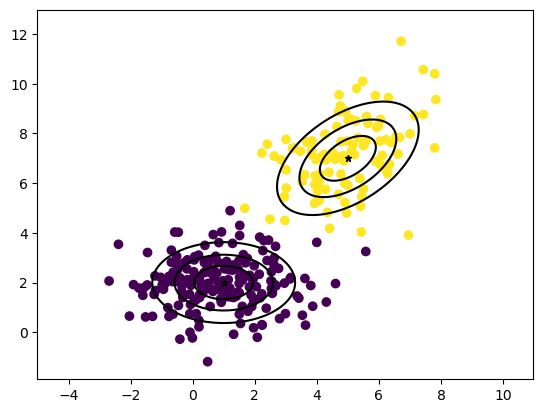

In [20]:
# evaluate the function on the dataset
probs = e_step(X, weights, components)

# compute to which component data points seem to belong
belong_to = probs.argmax(axis=0)

# plot data
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=belong_to)
for c in components:
    plot_2dnormal(c, color='black')
plt.show()

### (b)

Implement the M-step of the EM algorithm with a function `m_step(X, probs)` that receives as input
- the data `X` (an array of size $300 \times 2$ in the model above) and
- the probabilities `probs` (output of `e_step` implemented above, array of size $300 \times 2$ in the model above)

and outputs the updated parameter estimates of the Gaussian mixture model, i.e.,
- the weights of the mixture components (a list `[p, 1 - p]` in the model above) and
- the mixture components (a list of two [`multivariate_normal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) distributions in the model above).

*Hint:* The formulas for the updated parameter estimates can be found in eq. 10.16 in http://smlbook.org/.

In [21]:
def m_step(X, probs):
    
    sum_probs = probs.sum(axis=1)
    
    weights = sum_probs / probs.shape[1]
    mus = (probs @ X) / sum_probs[:, None]
    centeredX = X - mus[:, None, :]
    probs_centeredX = probs[..., None] * centeredX
    covs = (probs_centeredX.transpose(0,2,1) @ centeredX) / sum_probs[:, None, None]
    
    components = [
        multivariate_normal(mean=mu, cov=cov) for mu, cov in zip(mus, covs)
    ]
    
    return weights, components

We can perform a sanity check:

In [22]:
weights, components = m_step(X, probs)

print('weights:')
print(weights)
for i, c in enumerate(components):
    print('')
    print('Normal {}'.format(i+1))
    print('- mean:')
    print(c.mean)
    print('- cov:')
    print(c.cov)

weights:
[0.65713852 0.34286148]

Normal 1
- mean:
[0.92962014 1.99500452]
- cov:
[[1.94504919 0.01975103]
 [0.01975103 0.927303  ]]

Normal 2
- mean:
[4.89563384 7.10298781]
- cov:
[[1.7893407  0.90243919]
 [0.90243919 2.3372211 ]]


If everything went right, you should obtain estimates close to the ones used to generate the dataset:
- Mixture weights should be close to $[0.7, 0.3]$
- The first Gaussian mixture component should be close to
  \begin{equation*}
    \mathcal{N}\left(\begin{bmatrix} 1 \\ 2\end{bmatrix}, \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}\right)
  \end{equation*}
- The second Gaussian mixture component should be close to
  \begin{equation*}
    \mathcal{N}\left(\begin{bmatrix} 5 \\ 7\end{bmatrix}, \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}\right)
  \end{equation*}

### (c)

Run the code below to plot 3 iterations of the EM algorithm.

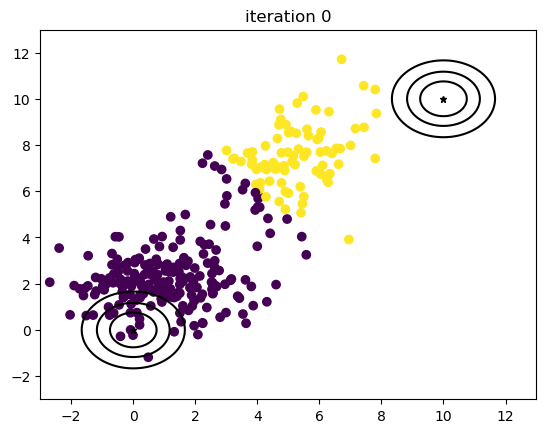

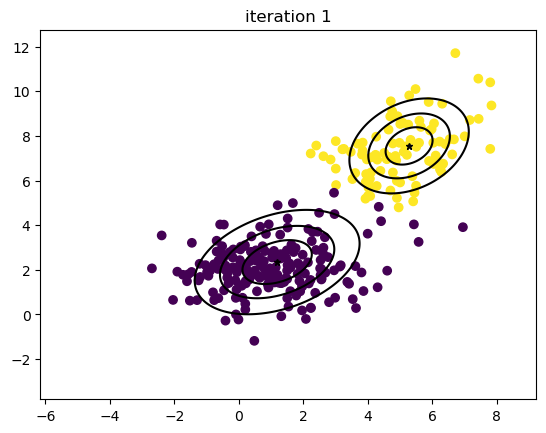

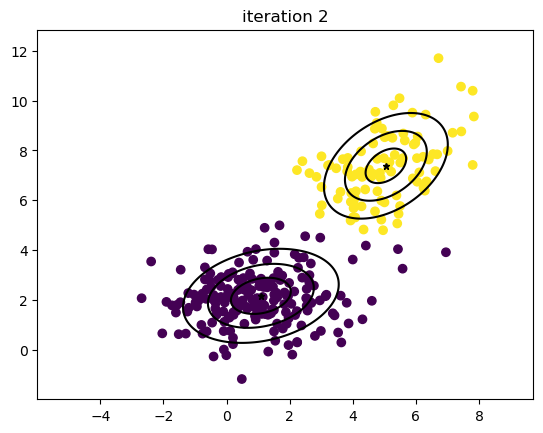

In [23]:
# initial parameter estimates
component1_estimated = multivariate_normal(mean=[0, 0], cov=np.eye(2))
component2_estimated  = multivariate_normal(mean=[10, 10], cov=np.eye(2))
components_estimated = [component1_estimated, component2_estimated]
weights_estimated = [0.5, 0.5]

for i in range(3):    
    # expectation step
    probs = e_step(X, weights_estimated, components_estimated)
    belong_to = probs.argmax(axis=0)
    
    # plot estimates
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=belong_to)
    for c in components_estimated:
        plot_2dnormal(c, color='black')
    plt.title(f"iteration {i}")
    plt.show()
    
    # maximization step
    weights_estimated, components_estimated = m_step(X, probs)

### (d)

Adapt the code in exercise 11.3 c) and use the EM algorithm to estimate the parameters of a Gaussian mixture model for the two-dimensional encodings of the MNIST training data set computed in exercise 11.1. You have to choose the number of mixture components and the initial parameter estimates.

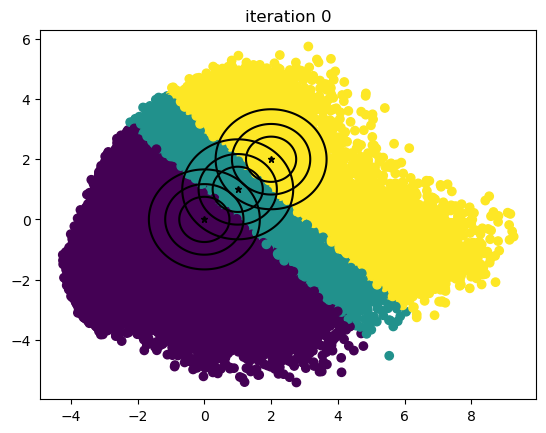

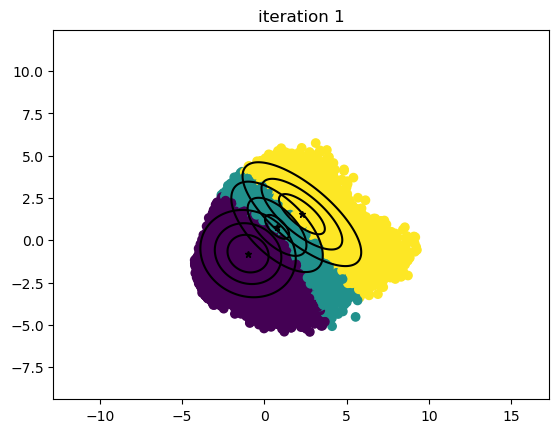

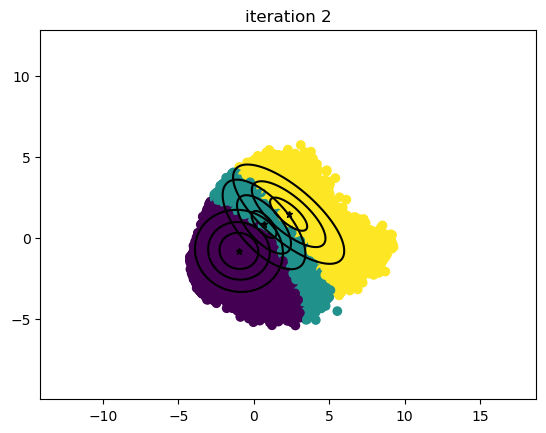

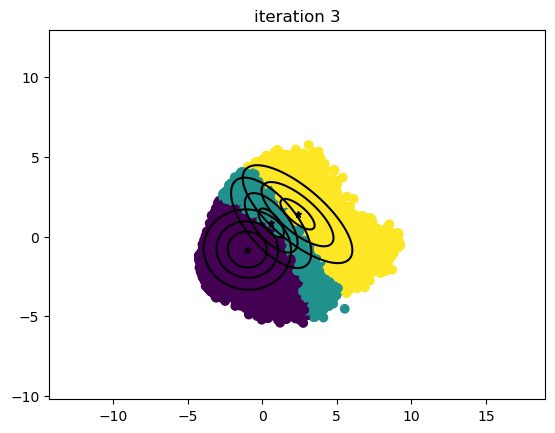

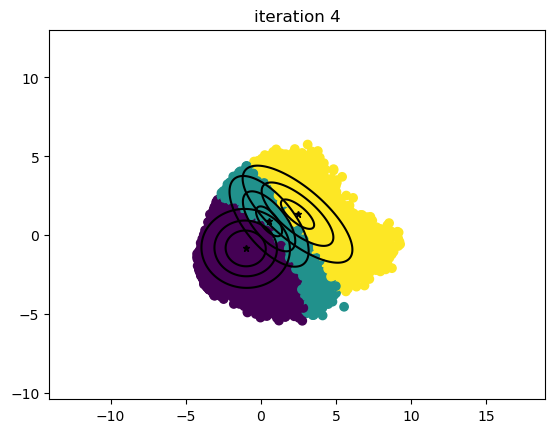

In [26]:
# initial parameter estimates
m = 3
components_estimated = [multivariate_normal(mean=[i,i], cov=np.eye(2)) for i in range(m)]
weights_estimated = [1 / m for _ in range(m)]

for i in range(5):    
    # expectation step
    probs = e_step(train_encodings, weights_estimated, components_estimated)
    belong_to = probs.argmax(axis=0)
    
    # plot estimates
    plt.figure()
    plt.scatter(train_encodings[:, 0], train_encodings[:, 1], c=belong_to)
    for c in components_estimated:
        plot_2dnormal(c, color='black')
    plt.title(f"iteration {i}")
    plt.show()
    
    # maximization step
    weights_estimated, components_estimated = m_step(train_encodings, probs)